In [ ]:
import gzip
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
# Téléchargement et extraction automatiques des données MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(root='C:/Users/hp/Downloads/archive (1)', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 89794994.99it/s]


Extracting C:/Users/hp/Downloads/archive (1)/MNIST/raw/train-images-idx3-ubyte.gz to C:/Users/hp/Downloads/archive (1)/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 97454299.13it/s]

Extracting C:/Users/hp/Downloads/archive (1)/MNIST/raw/train-labels-idx1-ubyte.gz to C:/Users/hp/Downloads/archive (1)/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23855551.60it/s]

Extracting C:/Users/hp/Downloads/archive (1)/MNIST/raw/t10k-images-idx3-ubyte.gz to C:/Users/hp/Downloads/archive (1)/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15313929.88it/s]


Extracting C:/Users/hp/Downloads/archive (1)/MNIST/raw/t10k-labels-idx1-ubyte.gz to C:/Users/hp/Downloads/archive (1)/MNIST/raw



In [ ]:
# Fonction pour décompresser les fichiers gzip
def extract_images_labels(images_file, labels_file):
    with gzip.open(images_file, 'rb') as f_images, gzip.open(labels_file, 'rb') as f_labels:
        images_data = np.frombuffer(f_images.read(), dtype=np.uint8, offset=16).reshape(-1, 28, 28)
        labels_data = np.frombuffer(f_labels.read(), dtype=np.uint8, offset=8)
    return images_data, labels_data


In [ ]:
# Chemins des fichiers d'images et d'étiquettes dans l'ensemble de test
test_images_file = 'C:/Users/hp/Downloads/archive (1)/MNIST/raw/t10k-images-idx3-ubyte.gz'
test_labels_file = 'C:/Users/hp/Downloads/archive (1)/MNIST/raw/t10k-labels-idx1-ubyte.gz'


In [ ]:
# Chargement des images et des étiquettes de l'ensemble de test
test_images, test_labels = extract_images_labels(test_images_file, test_labels_file)


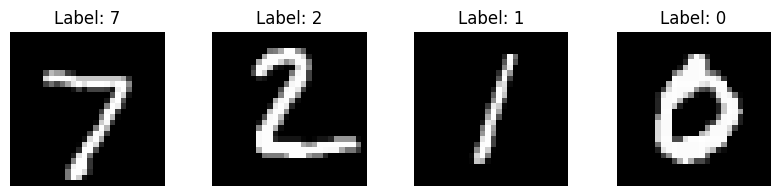

In [ ]:
import matplotlib.pyplot as plt

# Affichage de quelques images de l'ensemble de test
plt.figure(figsize=(10, 2))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f"Label: {test_labels[i]}")
    plt.axis('off')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Ajout de cette ligne
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Définir une architecture CNN simple
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Initialiser le modèle, la fonction de perte et l'optimiseur
net = Net()
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Entraîner le modèle (cette partie doit être exécutée sur GPU si possible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
num_epochs = 5
for epoch in range(num_epochs):
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Remettre à zéro les gradients, effectuer la propagation avant, calculer la perte et effectuer la rétropropagation
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("CNN Classifier training complete.") #5min d'execution

CNN Classifier training complete.


In [ ]:
# Charger les données de test
testset = TensorDataset(torch.Tensor(test_images).unsqueeze(1), torch.LongTensor(test_labels))
testloader = DataLoader(testset, batch_size=4, shuffle=False)


In [ ]:
# Évaluation du modèle sur l'ensemble de test
correct = 0
total = 0
net.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = correct / total
print(f'Accuracy on test set: {accuracy * 100:.2f}%')

# Calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f'F1 Score on test set: {f1 * 100:.2f}%')

# Calculate Loss
criterion = nn.CrossEntropyLoss()
test_loss = 0.0
total_test_samples = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        total_test_samples += labels.size(0)  # Ajout du nombre d'échantillons dans l'ensemble de test

average_loss = test_loss / total_test_samples  # Normalisation par rapport à la taille de l'ensemble de test
print(f'Average Loss on test set: {average_loss:.4f}')


Accuracy on test set: 95.76%
F1 Score on test set: 95.70%
Average Loss on test set: 3.5527


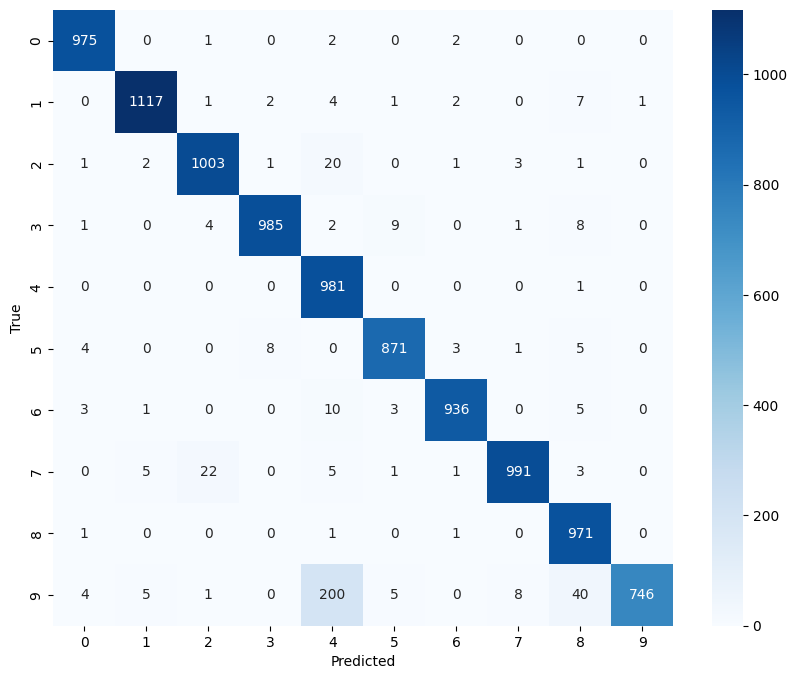

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
